In [11]:
starcoder = 'starcoder2'
llama = "llama3"
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
mistral_api_key = os.getenv("MISTRAL_API_KEY") # Ensure this is set
open_ai_key = os.getenv('OPENAI_API_KEY')
anthropic_key = os.getenv('ANTHROPIC_API_KEY')

from dotenv import load_dotenv

load_dotenv()

True

## Docs

In [12]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## LLM

In [13]:
# Select LLM
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

mistral_model = 'gpt-4o-mini'
llm = ChatOpenAI(model=mistral_model, temperature=0)

# Prompt 
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", 
            """You are a coding assistant. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
            \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."


code_gen_chain = code_gen_prompt | llm.with_structured_output(code)
question = "How do I build a RAG chain in LCEL?"

solution = code_gen_chain.invoke({"context":concatenated_content,"messages":[("user",question)]})
solution

code(prefix="This code demonstrates how to build a Retrieval-Augmented Generation (RAG) chain using LangChain and OpenAI's GPT model. The RAG chain combines retrieval of relevant documents with generative capabilities to produce informative responses.", imports='from langchain.chains import RetrievalQA\nfrom langchain.llms import OpenAI\nfrom langchain.vectorstores import FAISS\nfrom langchain.embeddings import OpenAIEmbeddings\nfrom langchain.document_loaders import TextLoader\nfrom langchain.text_splitter import CharacterTextSplitter\nimport os', code="# Load documents\nloader = TextLoader('path/to/your/documents')\ndocuments = loader.load()\n\n# Split documents into chunks\ntext_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)\nchunked_docs = text_splitter.split_documents(documents)\n\n# Create embeddings and vector store\nembeddings = OpenAIEmbeddings()\nvectordb = FAISS.from_documents(chunked_docs, embeddings)\n\n# Initialize the language model\nllm = OpenAI(mo

In [14]:
question = "Write a function for fibonacci."
messages = [("user", question)]

# Correctly invoking the method with a single dictionary containing both 'context' and 'messages'
result = code_gen_chain.invoke({'context': 'Use your knowledge', 'messages': messages})
print(result)

prefix='This function calculates the Fibonacci sequence up to a specified number of terms.' imports='from typing import List' code='def fibonacci(n: int) -> List[int]:\n    fib_sequence = []\n    a, b = 0, 1\n    for _ in range(n):\n        fib_sequence.append(a)\n        a, b = b, a + b\n    return fib_sequence' description='This function generates the Fibonacci sequence up to the nth term.'


## State

In [15]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

## Graph

In [16]:
from langchain_core.pydantic_v1 import BaseModel, Field

### Parameter

# Max tries
max_iterations = 3
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

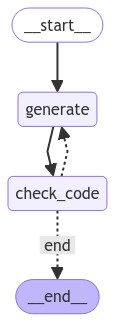

In [17]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
#workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges("check_code",
        decide_to_finish,
    {
        "end": END,
        #"reflect": "reflect",
        "generate": "generate",
    },
)
#workflow.add_edge("reflect", "generate")
my_graph = workflow.compile()
display(Image(my_graph.get_graph(xray=True).draw_mermaid_png()))

In [18]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
my_graph.invoke({"messages": [("user", question)], "iterations": 0})

---GENERATING CODE SOLUTION---
---CHECKING CODE---
Processed input: Hello, this is a test string.
---NO CODE TEST FAILURES---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user',
   'How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?'),
  ('assistant',
   "This code demonstrates how to pass a string to a runnable function and use it to construct the input needed for a prompt. The example includes a simple function that takes a string and processes it to generate a prompt input. \n Imports: import sys \n Code: def process_input(input_string):\n    # Constructing the prompt input from the string\n    prompt_input = f'Processed input: {input_string}'\n    return prompt_input\n\nif __name__ == '__main__':\n    # Example string to pass\n    input_string = 'Hello, this is a test string.'\n    result = process_input(input_string)\n    print(result)")],
 'generation': code(prefix='This code demonstrates how to pass a string to a runnable function and use it to construct the input needed for a prompt. The example includes a simple function that takes a string and processes it to g